---
# Préparation des données

---


Dans cette séquence, nous allons voir différentes techniques permettant de préparer adéquatement les données avant de les fournir à un ou plusieurs algorithmes d'apprentissage automatique.

<center><img src="./img/mlprocess_2.png" alt="Processus d'apprentissage automatique" width="50%"/></center>

Nous aborderons notamment les points suivants :

1. **Le nettoyage et les aberrations statistiques**
2. L'imputation de données manquantes
3. Équilibrage de données déséquilibrées
4. Transformation des caractéristiques
    1. *rescaling* et *normalizing* (\[0, 1\] ou \[-1, 1\]), *standardizing* (loi normale)
    2. Représentation matricielle de données catégorisées
    3. Réduction de la dimensionnalité ou création de caractéristiques

Et nous commençons dans ce premier module par les *outliers* ou aberrations statistiques.


## 1. Nettoyage et aberrations
### Traitement des données dupliquées

**Compter les valeurs uniques d'une colonne:**

```
df.groupby('ma_categorie').id_user.nunique()
```

**Montrer les valeurs dupliquées dans une colonne:**

```
pd.concat(i for _, i in df.groupby('id_user') if len(i) > 1)
```

Dans le cas où vous voudriez montrer les valeurs dupliquées pour une combinaison de colonnes, remplacez `id_user` par la liste des colonnes à considérer (e.g.  ['id_user', 'pays'])

**Retirer les données dupliquées:**

```
df = df.drop_duplicates(subset='id_user', keep=False)
```  

### Traitement des données aberrantes

La séquence suivante est inspirée des exemples de code de la librairie `scikit-learn` de [Alexandre Gramfort](mailto:alexandre.gramfort@inria.fr) et [Albert Thomas](mailto:albert.thomas@telecom-paristech.fr) (License: BSD 3 clause)

Nous allons commencer par générer plusieurs ensembles de données en y incluant des données aberrantes (ne faisant pas partie de la distribution réelle des données à modéliser), puis nous allons vous montrer diverses techniques permettant (avec plus ou moins de succès) de déterminer quelles données font partie de la distribution initiale, et lesquelles n'en font pas partie.

N'hésitez pas à jouer avec les paramètres des différents algorithmes pour voir l'implication de chacun!


In [1]:
# Import des librairies nécessaires
import time
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['contour.negative_linestyle'] = 'solid'
from sklearn.datasets import make_moons, make_blobs

In [2]:
# Paramètres des exemples
n_samples = 300
# Quantité de données aberrantes (en %)
outliers_fraction = 0.25


In [3]:
# Definition des datasets avec données aberrantes selon les paramètres précédents
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers

blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=2)
datasets = [# 5 datasets:
    # Un seul blob
    make_blobs(centers=[[0, 0], [0, 0]], cluster_std=0.5,
               **blobs_params)[0],
    # Deux blobs (distribution chameau)
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[0.5, 0.5],
               **blobs_params)[0],
    # Deux blobs dont un plus étalé
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[1.5, .3],
               **blobs_params)[0],
    # Deux lunes
    4. * (make_moons(n_samples=n_samples, noise=.05, random_state=0)[0] -
          np.array([0.5, 0.25])),
    # Bruit blanc
    14. * (np.random.RandomState(42).rand(n_samples, 2) - 0.5)]

# Grillage (mesh en anglais) pour afficher le contour de décision
xx, yy = np.meshgrid(np.linspace(-7, 7, 150),
                     np.linspace(-7, 7, 150))

In [4]:
# Fonction d'affichage des datasets (inliers et outliers) avec les lignes de démarcation.
def plot_datasets(name='', algorithm=None, addOutliers=True):
    # Taille des figures
    plt.figure(figsize=(len(datasets) * 2 + 3, 3))
    plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                        hspace=.01)
    
    plot_num = 1
    # Garantit la reproductibilité
    rng = np.random.RandomState(42)
    
    for i_dataset, X in enumerate(datasets):
        
        y_pred = np.repeat(0,len(X))
        # Ajoût des outliers
        if addOutliers:
            X = np.concatenate([X, rng.uniform(low=-6, high=6,size=(n_outliers, 2))], axis=0)
            # On met la vérité dans la prédiction si on ne fait pas de prédiction
            y_pred = np.concatenate([y_pred,np.repeat(1,n_outliers)],axis=0)

        t0 = 0
        t1 = 0
        ax = plt.subplot(1,len(datasets), plot_num)
        # Si on veut voir la prédiction dans l'affichage : 
        if algorithm != None:
            t0 = time.time()
            algorithm.fit(X)
            t1 = time.time()
            if i_dataset == 0:
                plt.title(name, size=18)
            # Fit les données et tag les outliers
            if name == "Local Outlier Factor": # LOF n'implémente pas la méthode predict
                y_pred = algorithm.fit_predict(X)
            elif name == "KDE": # KDE non plus
                # Score samples
                pred = np.exp(algorithm.fit(X).score_samples(X))
                n = sum(pred < 0.05)
                outlier_ind = np.asarray(pred).argsort()[:n]
                y_pred = np.array([-1 if i in outlier_ind else 1 for i in range(len(X))])
            elif name == "Tukey": # Et celui la non plus ... obviously
                outlier_ind = algorithm.outliers(X)
                y_pred = np.array([-1 if i in outlier_ind else 1 for i in range(len(X))])
            else: 
                y_pred = algorithm.fit(X).predict(X)
                # Affichage des points et de la ligne de démarcation
                Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
                Z = Z.reshape(xx.shape)
                plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')
            plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'), transform=plt.gca().transAxes, size=15, horizontalalignment='right')

            # Ajustement pour identifier en orange les outliers 
            y_pred = 1- y_pred

        colors = np.array(['#377eb8', '#ff7f00'])
        ax.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y_pred + 1) // 2])
        plt.xlim(-7, 7)
        plt.ylim(-7, 7)
        plt.xticks(())
        plt.yticks(())
        plot_num += 1
    plt.show()

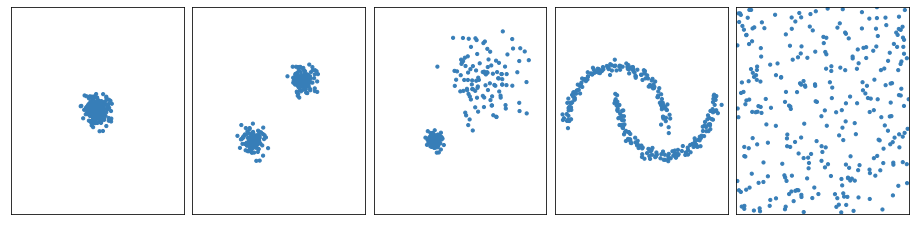

In [5]:
# Affichage des données sans outliers
plot_datasets(addOutliers=False)

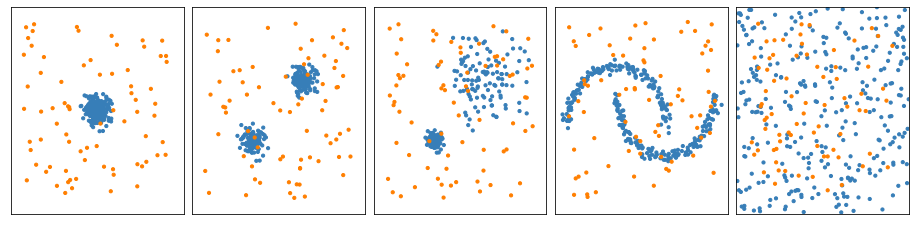

In [6]:
# Affichage avec outliers originaux
plot_datasets(addOutliers=True)

À partir d'ici nous allons essayer différents algorithmes de détection des *outliers*, les données hors distribution. Pour chacune des fonctions utilisées, n'hésitez pas à vous référer à la documentation en ligne disponible ici : [SciKit-Learn documentation](https://scikit-learn.org/stable/).

Généralement, une simple recherche sur Google de la fonction (par exemple ci-dessous, cherchez *EllipticEnvelope* sur [Google](https://www.google.com/search?q=EllipticEnvelope)) vous mènera directement à la bonne page de documentation.

La partie importante de cette documentation, qui n'est pas discutée dans ce *notebook*, est l'ensemble des paramètres arbitrairement fixés à leurs valeurs par défaut que vous voudriez peut-être essayer de corriger vu que vous connaissez déjà quelles sont les "bonnes" données et les "mauvaises" données.

#### Covariance robuste
Les points identifiés comme outliers (vrais ou faux) sont toujours affichés en orange.  

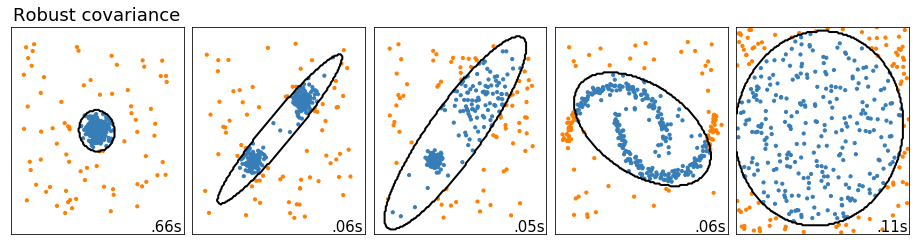

In [7]:
from sklearn.covariance import EllipticEnvelope

algo =  ("Robust covariance", EllipticEnvelope(contamination=outliers_fraction))

plot_datasets(*algo)

#### SVM monoclasse

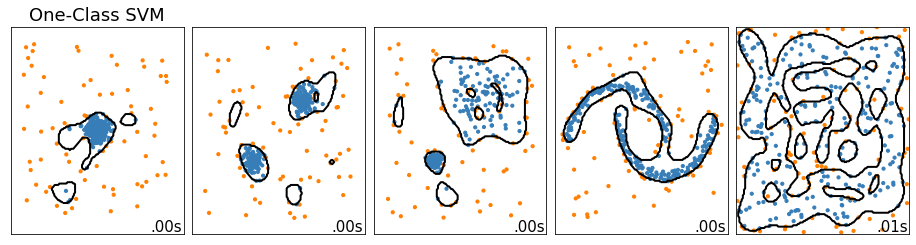

In [8]:
from sklearn import svm

algo = ("One-Class SVM", svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.3))

plot_datasets(*algo)

#### Forêt d'isolation

C:\Users\pgsci\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
C:\Users\pgsci\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
C:\Users\pgsci\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
C:\Users\pgsci\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
C:\Users\pgsci\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and w

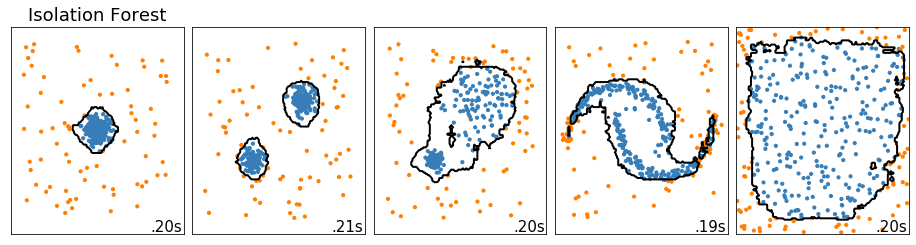

In [9]:
from sklearn.ensemble import IsolationForest

algo = ("Isolation Forest", IsolationForest(contamination=outliers_fraction, random_state=42))

plot_datasets(*algo)

#### Facteur d'aberration local

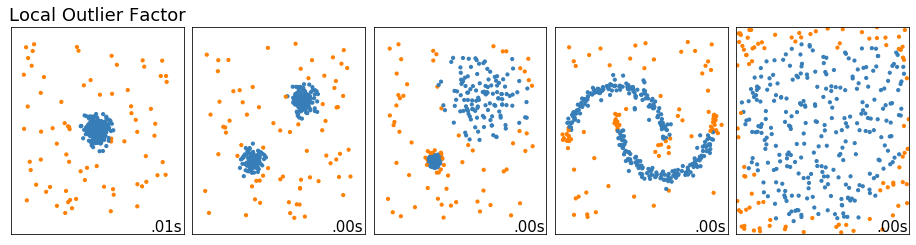

In [10]:
from sklearn.neighbors import LocalOutlierFactor

algo = ("Local Outlier Factor", LocalOutlierFactor(n_neighbors=35, contamination=outliers_fraction))

plot_datasets(*algo)


#### Test de Tukey pour les valeurs extrêmes

110
0
0
0
0


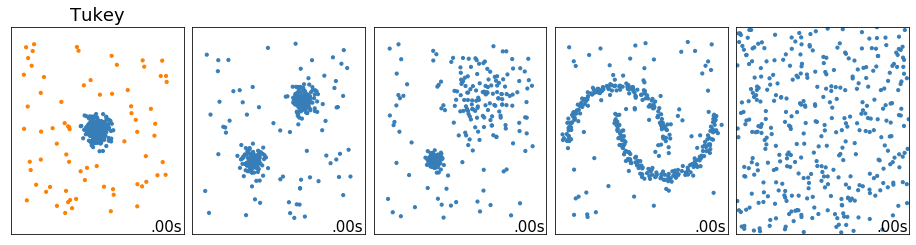

In [11]:
ecart = 1.5

# Definissons la fonction qui utilise les deviations interquartile avec les quartiles 1 et 3 comme plancher et plafond.
class Tukey:
    def fit(self, X):
        None
    def outliers(self,x):
        q1 = np.percentile(x, 25)
        q3 = np.percentile(x, 75)
        iqr = q3-q1 
        floor = q1 - ecart * iqr
        ceiling = q3 + ecart * iqr
        outlier_indices = np.where((x < floor)|(x > ceiling))[0]
        print(len(outlier_indices))
        return outlier_indices


algo = ('Tukey',Tukey())
plot_datasets(*algo)

### Estimation de densité par noyau (KDE)

Cette méthode non paramétrique peut aussi capturer les distributions bimodales.

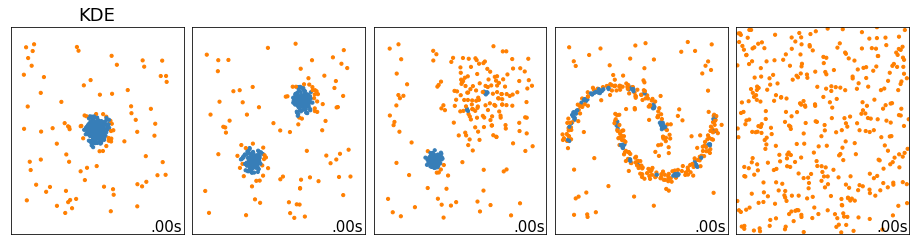

In [12]:
from sklearn.neighbors import KernelDensity

# Variez le type de noyau pour comparer les résultats 
# kernel : [‘gaussian’|’tophat’|’epanechnikov’|’exponential’|’linear’|’cosine’]

algo = ('KDE', KernelDensity(bandwidth=0.2,kernel='gaussian'))

plot_datasets(*algo)